Name: Aayam Raj Shakya (as5160)

In [1]:
# importing requried libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Loading wine dataset (Page 122)
df_wine = pd.read_csv('https://archive.ics.uci.edu/'
                      'ml/machine-learning-databases/wine/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol',
                   'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium',
                   'Total phenols', 'Flavanoids',
                   'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

# print('Class labels', np.unique(df_wine['Class label']))
df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [3]:
# Page 123
from sklearn.model_selection import train_test_split
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test =\
    train_test_split(X, y,
                     test_size=0.3,
                     random_state=0,
                     stratify=y)

# Page 126
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

6.1. On pp. 135-143, the sequential backward selection (SBS) is implemented as a
feature selection method and experimented with a k-NN classifier (n_neighbors=5), using the wine dataset.

In [4]:
from sklearn.base import clone
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):

        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train,
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train,
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

a. Perform the same experiment with the k-NN classifier replaced by the support vector machine (soft-margin SVM classification).

b. In particular, analyze accuracy of the soft-margin SVM and plot the result
as in the figure on p. 139.

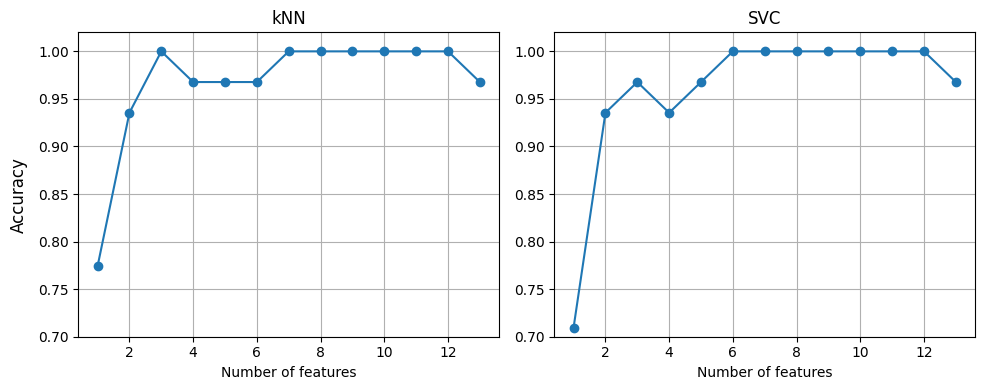

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

k_feat = [len(k) for k in sbs.subsets_]

ax[0].plot(k_feat, sbs.scores_, marker='o')
ax[0].set_ylim([0.7, 1.02])
ax[0].set_xlabel('Number of features')
ax[0].set_title('kNN')
ax[0].grid()

#------------------------------------------------------

from sklearn.svm import SVC

svm = SVC(kernel='linear', C=1.0)

sbs = SBS(estimator=svm, k_features=1)
sbs.fit(X_train_std, y_train)

k_feat = [len(k) for k in sbs.subsets_]

ax[1].plot(k_feat, sbs.scores_, marker='o')
ax[1].set_ylim([0.7, 1.02])
ax[1].set_xlabel('Number of features')
ax[1].set_title('SVC')
ax[1].grid()

fig.supylabel('Accuracy')
plt.tight_layout()
plt.show()

6.2. On pp. 141-143, the permutation feature importance is assessed from the random forest classifier, using the wine dataset.

a. Discuss whether or not you can derive feature importance for a k-NN classifier.

b. Assess feature importance with the logistic regression classifier, using the
same dataset.

c. Based on the computed feature importance, analyze and plot accuracy of the
logistic regression classifier for k_features = 1, 2, · · · , 13.

  Index  Labels                          Random forest    Logistic regression
-------  ----------------------------  ---------------  ---------------------
      1  Proline                             0.185453                1.00859
      2  Flavanoids                          0.174751                2.14855
      3  Color intensity                     0.14392                 1.2445
      4  OD280/OD315 of diluted wines        0.136162                1.56652
      5  Alcohol                             0.118529                1.56462
      6  Hue                                 0.058739                0.972831
      7  Total phenols                       0.0508724               1.18994
      8  Magnesium                           0.0313571               1.00611
      9  Malic acid                          0.0256484               1.74914
     10  Proanthocyanins                     0.0255699               1.14604
     11  Alcalinity of ash                   0.0223659               0.776

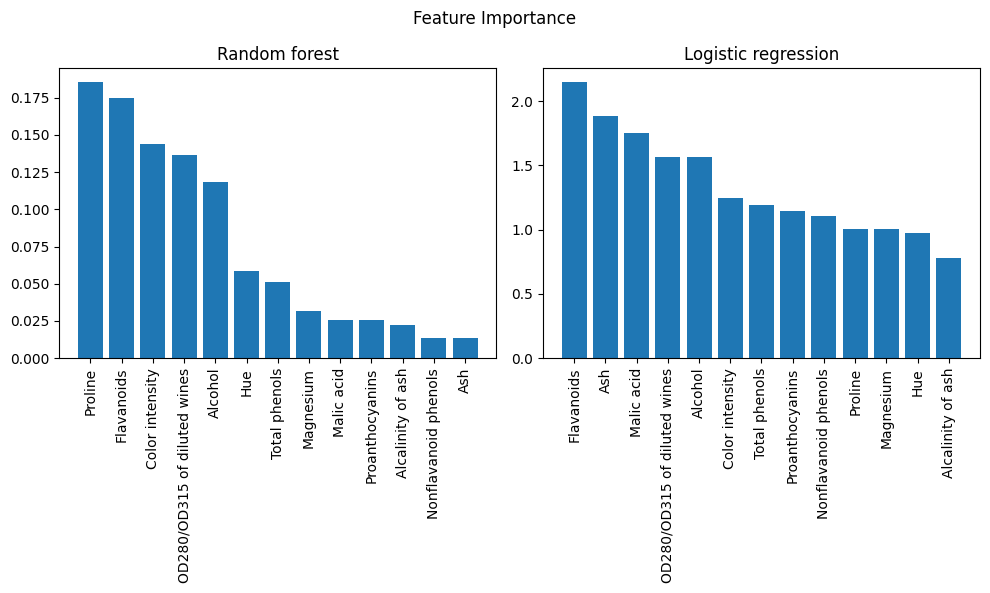



Random forest accuracy: 1.0000 and Logistic regression accuracy: 0.9630


In [6]:
# REFERENCE: https://shorturl.at/hlJ2Z

from tabulate import tabulate
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

feat_labels = df_wine.columns[1:]

forest = RandomForestClassifier(n_estimators=500, random_state=1)
logit = LogisticRegression(max_iter=10000, random_state=1)

forest.fit(X_train, y_train)
logit.fit(X_train, y_train)
forest_importances = forest.feature_importances_
logit_importances = np.exp(logit.coef_[0])

indices = np.argsort(forest_importances)[::-1]
logit_indices = np.argsort(logit_importances)[::-1]

table = []
for f in range(X_train.shape[1]):
  each_row = [f+1, feat_labels[indices[f]],
              forest_importances[indices[f]],
              logit_importances[indices[f]]]
  table.append(each_row)

headers = ["Index", "Labels", "Random forest", "Logistic regression"]
print(tabulate(table, headers=headers))
print('\n')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

# Plotting data
ax[0].set_title('Random forest')
ax[0].bar(range(X_train.shape[1]),
        forest_importances[indices],
        align='center')

ax[0].set_xticks(range(X_train.shape[1]),
           feat_labels[indices], rotation=90)
ax[0].set_xlim([-1, X_train.shape[1]])

#-----------------------------------------------------

ax[1].set_title('Logistic regression')
ax[1].bar(range(X_train.shape[1]),
        logit_importances[logit_indices],
        align='center')

ax[1].set_xticks(range(X_train.shape[1]),
           feat_labels[logit_indices], rotation=90)
ax[1].set_xlim([-1, X_train.shape[1]])

plt.suptitle("Feature Importance")
plt.tight_layout()
plt.show()


# Calculate accuracy
forest_pred = forest.predict(X_test)
forest_accuracy = accuracy_score(y_test, forest_pred)

logit_pred = logit.predict(X_test)
logit_accuracy = accuracy_score(y_test, logit_pred)

print(f"\n\nRandom forest accuracy: {forest_accuracy:.4f}\
 and Logistic regression accuracy: {logit_accuracy:.4f}")